In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD4'].copy()
adata

AnnData object with n_obs × n_vars = 19660 × 6770
    obs: 'channel', 'barcode', 'timepoint', 'timepoint_fine', 'product', 'generic', 'nTisa', 'nAxi', 'CAR', 'n_genes_by_counts', 'total_counts', 'response', 'cdr3_TRA', 'cdr3_TRB', 'batch_id', 'organization', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'n_counts', 'leiden_0.9', 'cell_type', 'category', 'category_response'
    var: 'feature_types', 'gene_ids-0', 'genome-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'genome-0-1', 'genome-1-1', 'genome-2-1', 'genome-3-1', 'genome-4-1', 'genome-5-1', 'genome-6-1', 'genome-7-1', 'genome-8-1', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

/tmp/ipykernel_962242/1239573043.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962242/1239573043.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962242/1239573043.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962242/1239573043.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962242/1239573043.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962242/1239573043.py:85: Deprecatio

Error for cluster 15: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=2.


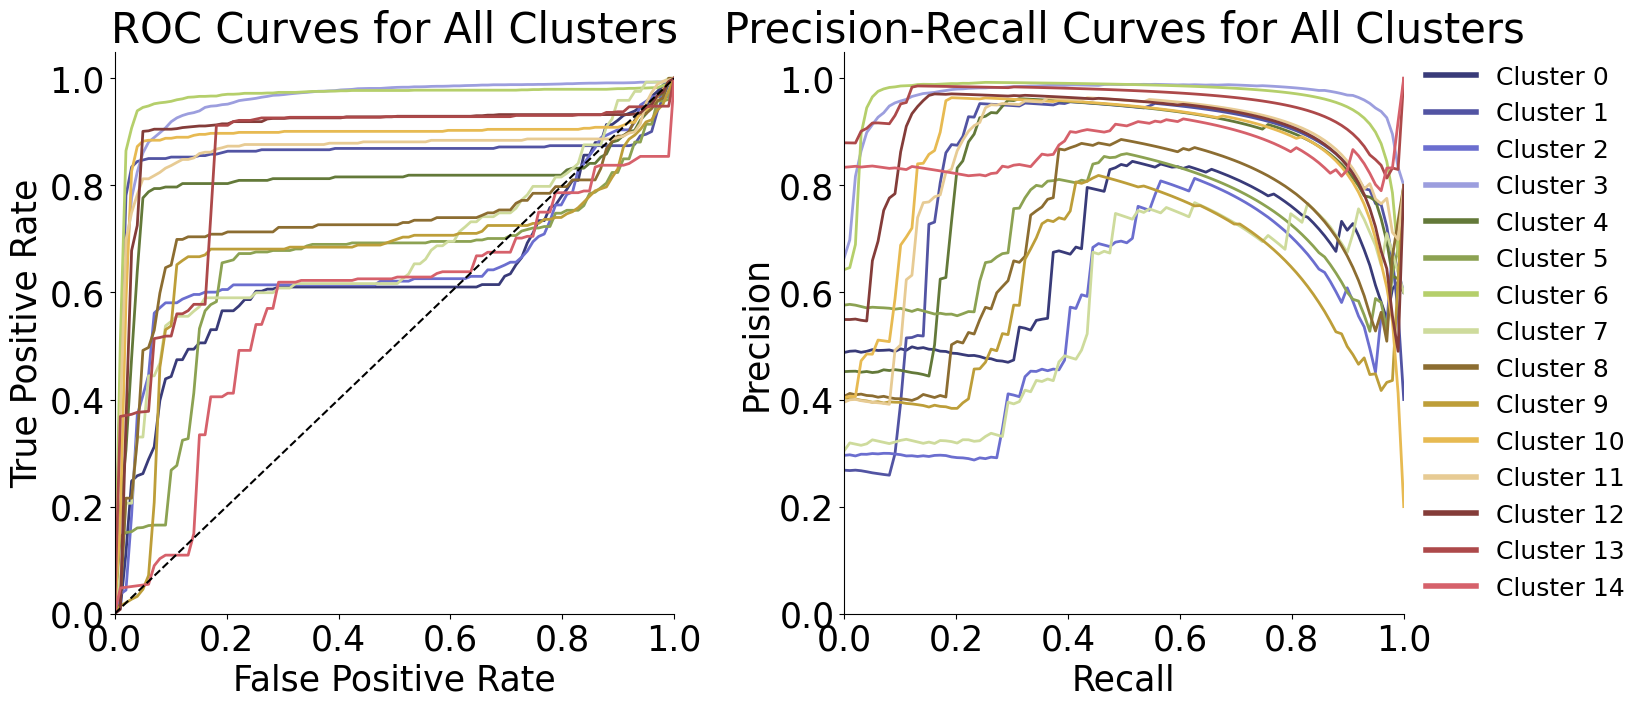

    Cluster  Accuracy  Precision    Recall  F1-Score   AUC-ROC    AUC-PR
0         0  0.707677   0.816598  0.523310  0.636543  0.632080  0.662472
1         1  0.935876   0.952901  0.799042  0.868046  0.861105  0.819469
2         2  0.827337   0.793365  0.547263  0.644815  0.653971  0.551197
3         3  0.911291   0.935138  0.931299  0.933157  0.955543  0.966736
4         4  0.871831   0.949540  0.757119  0.842165  0.807614  0.819164
5         5  0.733740   0.867663  0.633325  0.731293  0.647464  0.707706
6         6  0.945747   0.970045  0.944770  0.957179  0.963023  0.962359
7         7  0.792957   0.753419  0.455694  0.567211  0.676177  0.565221
8         8  0.814001   0.880356  0.635638  0.733849  0.727613  0.692679
9         9  0.797037   0.816285  0.640458  0.716559  0.673058  0.604685
10       10  0.930110   0.953710  0.867085  0.907785  0.888718  0.851063
11       11  0.891788   0.911635  0.801988  0.852602  0.868428  0.849361
12       12  0.922696   0.955926  0.900941  0.92731

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, precision_score, recall_score, accuracy_score, f1_score
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import interp

adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD4'].copy()

# Unique clusters
clusters = adata.obs['leiden_0.9'].unique()

# Initialize lists to store metrics for each cluster
roc_curves = []
pr_curves = []
general_metrics = []

n_splits = 5  

for cluster in clusters:
    try:
        # Subset the data for the current cluster
        cluster_adata = adata[adata.obs['leiden_0.9'] == cluster].copy()
        
        # Get the data matrix and labels
        data = cluster_adata.X.toarray() if not isinstance(cluster_adata.X, np.ndarray) else cluster_adata.X
        labels = cluster_adata.obs['response'].apply(lambda x: 0 if x == 'CR' else 1).values
        
        # Initialize cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # Initialize metrics
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_rocs = []
        auc_prs = []
        
        # For average ROC and PR curves
        tprs = []
        precisions = []
        mean_fpr = np.linspace(0, 1, 100)
        mean_recall = np.linspace(0, 1, 100)
        
        for train_index, test_index in kf.split(data):
            # Split the data into training and testing sets for the current fold
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Check if the training data has at least two classes
            if len(np.unique(y_train)) < 2:
                raise ValueError(f"Cluster {cluster} does not have at least two classes in the training data.")
            
            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train the Logistic Regression classifier
            model = LogisticRegression(random_state=42)
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            # Calculate metrics for the current fold
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            
            # ROC and PR calculations
            # auc_roc = roc_auc_score(y_test, y_pred_proba) for individual fold
            # auc_rocs.append(auc_roc)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0  # Ensure the curve starts at (0,0)
            
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_interp = np.interp(mean_recall[::-1], recall[::-1], precision[::-1])
            precisions.append(pr_interp)
            # auc_pr = auc(recall, precision) for individual fold
            # auc_prs.append(auc_pr)
        
        # Average ROC and PR curves
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)
        mean_auc_roc = auc(mean_fpr, mean_tpr)
        
        mean_precision = np.mean(precisions, axis=0)
        mean_auc_pr = auc(mean_recall, mean_precision)
        
        # Store general metrics
        general_metrics.append({
            'Cluster': int(cluster),
            'Accuracy': np.mean(accuracy_scores),
            'Precision': np.mean(precision_scores),
            'Recall': np.mean(recall_scores),
            'F1-Score': np.mean(f1_scores),
            'AUC-ROC': mean_auc_roc,
            'AUC-PR': mean_auc_pr
        })
        
        # Store curves for plotting
        roc_curves.append((mean_fpr, mean_tpr, int(cluster), mean_auc_roc))
        pr_curves.append((mean_recall, mean_precision, int(cluster), mean_auc_pr))
        
        
    except ValueError as e:
        print(f"Error for cluster {cluster}: {e}")
        continue

import matplotlib.pyplot as plt
from cycler import cycler

# Sort the curves by cluster number
roc_curves = sorted(roc_curves, key=lambda x: x[2])
pr_curves = sorted(pr_curves, key=lambda x: x[2])

# Define a color cycle for better visualization
colors = plt.cm.tab20b.colors

# Plot ROC Curves for all clusters
plt.figure(figsize=(20, 8))
plt.rcParams['font.size'] = 25

# ROC Curve plot
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, (mean_fpr, mean_tpr, cluster, mean_auc_roc) in enumerate(roc_curves):
    plt.plot(mean_fpr, mean_tpr, color=colors[i % len(colors)], label=f'Cluster {cluster} (AUC = {mean_auc_roc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Clusters')

# Precision-Recall Curve plot
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, (mean_recall, mean_precision, cluster, mean_auc_pr) in enumerate(pr_curves):
    plt.plot(mean_recall, mean_precision, color=colors[i % len(colors)], label=f'Cluster {cluster} (AUC = {mean_auc_pr:.2f})', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Clusters')

# Create custom legend handles with thicker lines
legend_handles = [Line2D([0], [0], color=colors[i % len(colors)], linewidth=4, label=f'Cluster {cluster}')
                  for i, (mean_fpr, mean_tpr, cluster, mean_auc_roc) in enumerate(roc_curves)]

# Add legend to the side of the plot without frame and thicker lines
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, frameon=False)

plt.suptitle('')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend
plt.show()

# Convert general metrics to DataFrame and sort by cluster number
metrics_df = pd.DataFrame(general_metrics)
metrics_df = metrics_df.sort_values('Cluster')  # Sort by Cluster number
metrics_df = metrics_df.reset_index(drop=True)  # Reset index after sorting
print(metrics_df)


/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: Deprecatio

Error for cluster 15: Only one class present in y_true. ROC AUC score is not defined in that case.


/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_962540/4253165891.py:85: Deprecatio

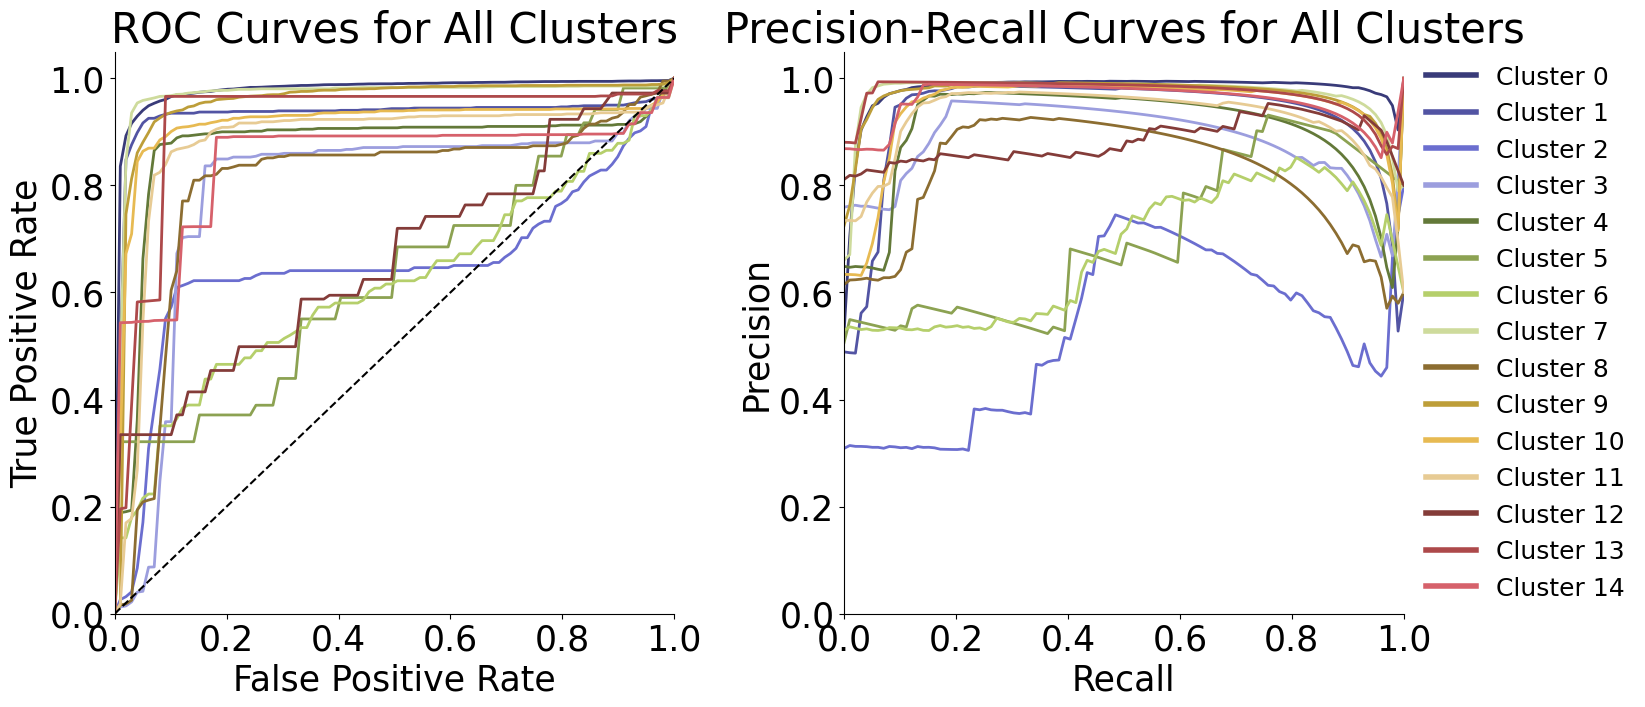

    Cluster  Accuracy  Precision    Recall  F1-Score   AUC-ROC    AUC-PR
0         0  0.945453   0.960153  0.935402  0.947518  0.977876  0.979345
1         1  0.927749   0.962643  0.886792  0.922888  0.931660  0.924546
2         2  0.794106   0.718538  0.523293  0.604614  0.651232  0.519000
3         3  0.839878   0.932186  0.850965  0.889294  0.788063  0.880435
4         4  0.895443   0.946543  0.888542  0.916482  0.872953  0.900688
5         5  0.560000   0.600000  0.120808  0.200932  0.627727  0.698641
6         6  0.641613   0.798889  0.411717  0.539813  0.613784  0.673334
7         7  0.955590   0.974700  0.957734  0.966071  0.968769  0.972065
8         8  0.834123   0.912247  0.809454  0.857347  0.801337  0.816605
9         9  0.920577   0.937462  0.954387  0.945766  0.954945  0.967464
10       10  0.897646   0.953606  0.880577  0.915547  0.916615  0.943722
11       11  0.878367   0.920701  0.910810  0.915628  0.880000  0.922845
12       12  0.438889   0.889381  0.346841  0.49146

In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, precision_score, recall_score, accuracy_score, f1_score
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import interp

adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD8'].copy()

# Unique clusters
clusters = adata.obs['leiden_0.9'].unique()

# Initialize lists to store metrics for each cluster
roc_curves = []
pr_curves = []
general_metrics = []

n_splits = 5 

for cluster in clusters:
    try:
        # Subset the data for the current cluster
        cluster_adata = adata[adata.obs['leiden_0.9'] == cluster].copy()
        
        # Get the data matrix and labels
        data = cluster_adata.X.toarray() if not isinstance(cluster_adata.X, np.ndarray) else cluster_adata.X
        labels = cluster_adata.obs['response'].apply(lambda x: 0 if x == 'CR' else 1).values
        
        # Initialize cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # Initialize metrics
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_rocs = []
        auc_prs = []
        
        # For average ROC and PR curves
        tprs = []
        precisions = []
        mean_fpr = np.linspace(0, 1, 100)
        mean_recall = np.linspace(0, 1, 100)
        
        for train_index, test_index in kf.split(data):
            # Split the data into training and testing sets for the current fold
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Check if the training data has at least two classes
            if len(np.unique(y_train)) < 2:
                raise ValueError(f"Cluster {cluster} does not have at least two classes in the training data.")
            
            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train the Logistic Regression classifier
            model = LogisticRegression(random_state=42)
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            # Calculate metrics for the current fold
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            
            # ROC and PR calculations
            # auc_roc = roc_auc_score(y_test, y_pred_proba) # metric for individual fold
            # auc_rocs.append(auc_roc)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0  # Ensure the curve starts at (0,0)
            
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_interp = np.interp(mean_recall[::-1], recall[::-1], precision[::-1])
            precisions.append(pr_interp)
            # auc_pr = auc(recall, precision) # metric for individual fold
            # auc_prs.append(auc_pr)
        
        # Average ROC and PR curves
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)
        mean_auc_roc = auc(mean_fpr, mean_tpr)
        
        mean_precision = np.mean(precisions, axis=0)
        mean_auc_pr = auc(mean_recall, mean_precision)
        
        # Store general metrics
        general_metrics.append({
            'Cluster': int(cluster),
            'Accuracy': np.mean(accuracy_scores),
            'Precision': np.mean(precision_scores),
            'Recall': np.mean(recall_scores),
            'F1-Score': np.mean(f1_scores),
            'AUC-ROC': mean_auc_roc,
            'AUC-PR': mean_auc_pr
        })
        
        # Store curves for plotting
        roc_curves.append((mean_fpr, mean_tpr, int(cluster), mean_auc_roc))
        pr_curves.append((mean_recall, mean_precision, int(cluster), mean_auc_pr))
        
    except ValueError as e:
        print(f"Error for cluster {cluster}: {e}")
        continue

import matplotlib.pyplot as plt
from cycler import cycler

# Sort the curves by cluster number
roc_curves = sorted(roc_curves, key=lambda x: x[2])
pr_curves = sorted(pr_curves, key=lambda x: x[2])

colors = plt.cm.tab20b.colors

# Plot ROC Curves for all clusters
plt.figure(figsize=(20, 8))
plt.rcParams['font.size'] = 25

# ROC Curve plot
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, (mean_fpr, mean_tpr, cluster, mean_auc_roc) in enumerate(roc_curves):
    plt.plot(mean_fpr, mean_tpr, color=colors[i % len(colors)], label=f'Cluster {cluster} (AUC = {mean_auc_roc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Clusters')

# Precision-Recall Curve plot
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, (mean_recall, mean_precision, cluster, mean_auc_pr) in enumerate(pr_curves):
    plt.plot(mean_recall, mean_precision, color=colors[i % len(colors)], label=f'Cluster {cluster} (AUC = {mean_auc_pr:.2f})', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Clusters')

# Create custom legend handles with thicker lines
legend_handles = [Line2D([0], [0], color=colors[i % len(colors)], linewidth=4, label=f'Cluster {cluster}')
                  for i, (mean_fpr, mean_tpr, cluster, mean_auc_roc) in enumerate(roc_curves)]

# Add legend to the side of the plot without frame and thicker lines
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, frameon=False)

plt.suptitle('')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend
plt.show()

# Convert general metrics to DataFrame and display
metrics_df = pd.DataFrame(general_metrics)
metrics_df = metrics_df.sort_values('Cluster')  # Sort by Cluster number
metrics_df = metrics_df.reset_index(drop=True)  # Reset index after sorting
print(metrics_df)